<a href="https://colab.research.google.com/github/samanthajmichael/ml_project/blob/main/notebooks/Model_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install tensorflow ffmpeg-python opencv-python matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.models import Model

In [15]:
df = pd.read_pickle("/content/drive/MyDrive/ML Project/middle_15min_frames.pkl")

In [17]:
df.describe()

,frame_number
count,20700.000000
mean,92814.500000
std,5975.719622
min,82465.000000
25%,87639.750000
50%,92814.500000
75%,97989.250000
max,103164.000000


In [18]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/ML Project/trained_base_model.h5', compile=False)

In [19]:
print(loaded_model)

<Functional name=functional_3, built=True>


In [26]:
def load_and_preprocess_frame(frame_data, target_size=(224, 224)):
    nparr = np.frombuffer(frame_data, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_decoder(input_shape=(128,)):
    inputs = tf.keras.Input(shape=input_shape)
    x = Dense(512, activation='relu')(inputs)
    x = Dense(1024, activation='relu')(x)
    x = Dense(224 * 224 * 3, activation='sigmoid')(x)
    outputs = Reshape((224, 224, 3))(x)
    return Model(inputs=inputs, outputs=outputs)

decoder = create_decoder()
decoder.compile(optimizer='adam', loss='mse')

def generate_decoder_data(model, df, batch_size=32):
    while True:
        batch = df.sample(n=batch_size)
        frames = np.array([load_and_preprocess_frame(frame_data) for frame_data in batch['frame_data']])
        features = model.predict(frames)
        yield features, frames

def train_decoder(model, decoder, df, epochs=1, steps_per_epoch=50, batch_size=32):
    generator = generate_decoder_data(model, df, batch_size)

    history = decoder.fit(
        generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1
    )

    return history

In [27]:
# Train the decoder
history = train_decoder(loaded_model, decoder, df, epochs=1, steps_per_epoch=50, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [30]:
# Save the trained decoder
decoder.save('/content/drive/MyDrive/ML Project/trained_decoder.h5')

In [31]:
def preprocess_frame_for_prediction(frame_data, target_size=(224, 224)):
    img = load_and_preprocess_frame(frame_data, target_size)
    return np.expand_dims(img, axis=0)  # Add batch dimension

In [32]:
def predict_frame(model, frame_data):
    preprocessed_frame = preprocess_frame_for_prediction(frame_data)
    prediction = model.predict(preprocessed_frame)
    return prediction

In [33]:
import matplotlib.pyplot as plt

def predict_and_visualize_frame(model, decoder, frame_data):
    # Make prediction
    prediction = predict_frame(model, frame_data)

    # Decode the prediction
    decoded_prediction = decoder.predict(prediction)

    # Reshape and denormalize the decoded prediction
    decoded_image = (decoded_prediction[0] * 255).astype(np.uint8)

    # Display the original and predicted frames
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original frame
    original_frame = load_and_preprocess_frame(frame_data)
    ax1.imshow(original_frame)
    ax1.set_title('Original Frame')
    ax1.axis('off')

    # Predicted frame
    ax2.imshow(decoded_image)
    ax2.set_title('Predicted Frame')
    ax2.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


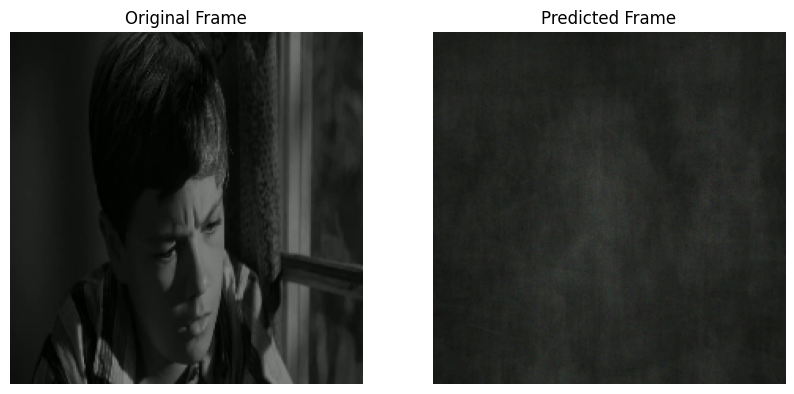

In [34]:
loaded_decoder = tf.keras.models.load_model('/content/drive/MyDrive/ML Project/trained_decoder.h5', compile=False)

# Assuming you have a frame to predict
frame_to_predict = df['frame_data'].iloc[0]  # Get the first frame from your dataframe

# Predict and visualize
predict_and_visualize_frame(loaded_model, loaded_decoder, frame_to_predict)